# Introduction to Calculus

---

# Exercises

In a typical calculus course, you'll spend a lot of time doing a bunch of analytical derivatives and integrals by hand of functions that don't necessarily have any real-world meaning. For the purpose of this workshop and this program in general, I don't think it will be very useful to practice calculus for the sake of calculus. For this reason, the following exercises are based on real examples where applications of calculus can be useful. 

In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy.linalg as lin
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

---
## 1. Linearized velocity

I know what you're all thinking: it's been way too long since we played with some of CRE181's data. If you remember back to our example in lecture, we only plotted the CRE181's velocity in the x-dimension. However, since CRE181 is running around in circles, only using the x-dimension will only give half the story. To get the full picture of CRE181's running, we need the velocity in both the x- and y-dimension. One way to do that is to compute both the x-velocity and y-velocity and represent the overall velocity as a vector. However, many analyses become more complicated with additional dimensions. In some situations, like that in an open-field box, there's not much you can do. In other situations, like in our case of a circle track, we can linearize the position into one relevant dimension. Recall the following relationships from trigonometry:

$$
r = \sqrt{x^2 + y^2} \\
\theta = \tan^{-1}\left(\frac{y}{x}\right)
$$

The above equations represent the trasformation from cartesian coordinates ($x$ and $y$) to polar coordinates ($r$ and $\theta$). In polar coordinates, there is only one variable that contains relevant information about the position and velocity, namely $\theta$. If your x- and y-coordinates are centered at the midpoint of the circle track, then $r$ will remain (mostly) constant and only $\theta$ will move according to the position on the circle track.

For the first exercise, we're going to apply this transformation to CRE181's position data to linearize the position and then compute the linearized velocity. First, for this transformation to work, we need to center our x and y coordinates at 0, i.e. put the center of the circle track at (0,0).

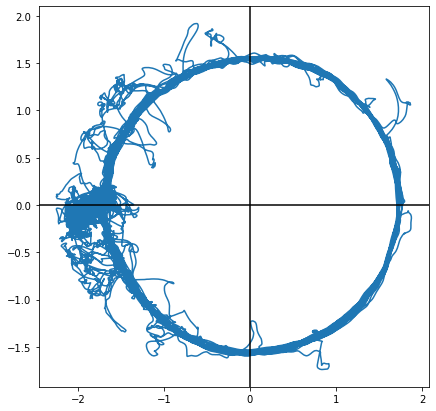

In [2]:
# load data
tmp = loadmat('CRE181_positionData.mat');
data = tmp['data']
ts = data[:,0]
x_orig = data[:,1]/100 # convert to meters
y_orig = data[:,2]/100

# 1. find the offset that will center the coordinates around zero
# you can do this mathematically or graphically
# I used '%matplotlib notebook' on interactive plots
# I hovered over the endpoints of the circle in both dimensions, and took the mean to get the center point
x_mid = np.mean([0.53,3.97])
y_mid = np.mean([0.18,3.3])

# 2. offset the original coordinates into new ones
x = x_orig-x_mid
y = y_orig-y_mid

# 3. plot to see if it worked!
plt.figure(figsize=(7,7))
plt.plot(x,y);
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

Once we have our circle centered, we can move on to converting the coordinates using the above equations. I suggest using the function ``np.arctan2``, which will give the full range of values between $-\pi$ to $\pi$; however, I would convert this to be from $0$ to $2\pi$ -- we don't want any negative distances! 

Once we compute our position in polar coordinates, we'll run into a new issue: there will be points in the data that from $2\pi$ to $0$ and make it look like CRE181 is making a reverse-lap at lightning speeds. Remember that CRE181 dislikes turning around, and he is also incapable of moving at super-rat speeds; therefore, we'll need to compute a continuous estimate of position which we can do by taking the *cumulative sum* of the *difference in position* at each timestamp. To help with this computation, I've provided a helpful function, ``circDiff``, which computes the circular difference between adjacent time steps. This function compares the difference in position $\Delta\theta$ to both $\Delta\theta+2\pi$ and $\Delta\theta -2\pi$ and figures out which of the three has the smallest magnitude. In this way, it accounts for lap resets that appear to jump between $0$ and $2\pi$ and translates it to the actual change in position that occurred.

Lastly, having position in radians (the units of $\theta$) is hard to inuitively interpret. Therefore, it will be useful to convert the position from radians to meters. We can make this conversion using the *circumference* of the circle. Recall that the circumference $C = 2\pi r$ represents the distance around the outside of the circle. Use this, with the knowledge that $2\pi$ radians represent a completed circle, to convert radians to meters.

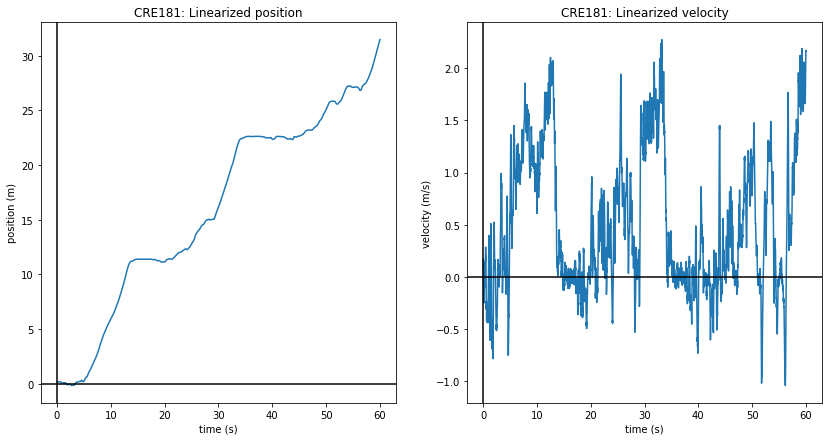

In [3]:
# helpful function
def circDiff(data):
    cycle = 2*np.pi      # this is when the cycle resets    
    diffData = np.diff(data)
    diffData2 = np.vstack((diffData,diffData+cycle,diffData-cycle)) # make an array with the diff, and the diff+cycle and diff-cycle
    min_inds = np.argmin(abs(diffData2),axis=0)  # figure out which of the three has the smallest magnitude
    return diffData2[(min_inds,np.arange(len(min_inds)))] # return the difference with the smallest magnitude

# 1. compute theta as well as the cumulative sum of theta to get a continuous estimate of distance
theta = -1*np.arctan2(y,x) + np.pi  # I flipped this to make CRE181 appear to run clockwise instead of counter-clockwise; this is totally not required
cum_theta = np.cumsum(np.hstack((theta[0],circDiff(theta))))

# 2. using the circumference, convert theta from radians to meters
r = np.sqrt(x**2+y**2)
circumf = 2*np.pi*np.mean(r)
cum_pos = circumf * cum_theta/(2*np.pi)

# 3. compute the velocity as m/s
vel = np.diff(cum_pos)/np.diff(ts)

# 4. plot your results, both the position and velocity on separate plots
# it might be helpful to zoom in to a subset of the session
_, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ax1.plot(ts[:3000],cum_pos[:3000]);
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('position (m)');
ax1.set_title("CRE181: Linearized position");


ax2.plot(ts[:3000],vel[:3000]);
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('velocity (m/s)');
ax2.set_title("CRE181: Linearized velocity");

---
## 2. Firing rate

While I could watch CRE181 run in circles all day, you might be wondering, "Where's the brain in all of this? I thought we were in a neuroscience program." Well luckily CRE181 wasn't *just* running in circles -- he was running in circles while recording spiking data from his dorsal hippocampus! Derivatives are useful in the realm of spiking data as well; it's good to know *firing rates*, which is a measure of spikes/second, to understand how neurons respond to the environment.

Here's where we run into a new problem. The spiking data is being recorded at 30 kHz; since the spiking activity of pyramidal cells in the hippocampus is fairly sparse, this is an unreasonably high sampling rate to get any meaningful firing rates. Additionally, the data is formatted a bit differently that our position data. For the position data, we had a vector of timestamps and a separate vector of positions corresponding to each timestamp. For the spiking data, we only have a vector of *spike times*, or timestamps at which the spikes occurred. You can imagine these spikes as a vector of $1$s and $0$s, where every value of $1$ corresponds to a spike; the vector we are given is only the time stamps at which all of the $1$s occur, and nothing for when there are $0$s. This makes for a much smaller vector to deal with, but will make the process of computing the derivative a bit different that what we did for position.

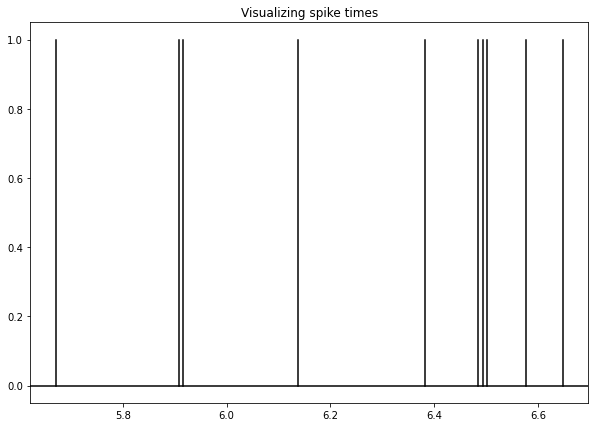

In [4]:
# load data
tmp = loadmat('CRE181_spikingData.mat');
data = tmp['data']

# this is how you access the first neuron -- the second is data[0][1], third is data[0][2], and so on
# what this gives you is an array of timestamps at which spikes occurred
spike_times = data[0][0]

# visualizing the spikes
plt.figure(figsize=(10,7))
for i in np.arange(10):
    plt.plot([spike_times[i],spike_times[i]],[0,1],'k')

plt.axhline(y=0, color='k')
plt.title('Visualizing spike times')
plt.show()
         

To compute the firing rate, then, we'll first need to define some new time bins to average the firing rate in a way that's more easily intepretable. I would suggest starting with time bins of width $250$ ms. Once those time bins are defined, you will need to count the number of spikes that occur in each bin, i.e. count the number of spike times that fall in each bin, and divide by the width of the bin to get the average firing rate:

$$
\text{firing_rate}(t) \approx \frac{\sum_t^{t+\Delta t} \text{spike_times}}{\Delta t}
$$

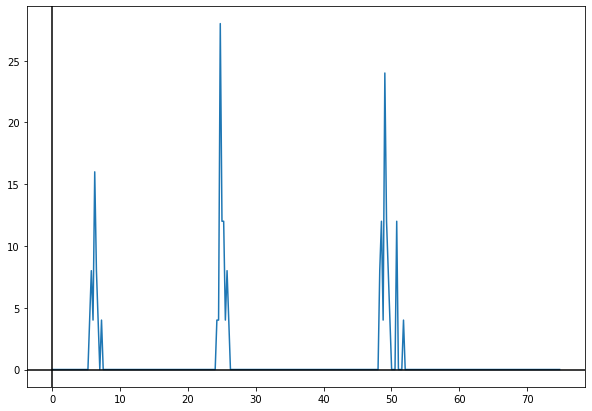

In [5]:
# get the spike times
spike_times = data[0][0]

# 1. define new time bins to average the data
dt = 0.25;
ts_bins = np.arange(ts[0],ts[-1],dt)

# 2. count the number of spikes in each bin
spike_counts,_ = np.histogram(spike_times,ts_bins)

# 3. divide by the time-width of the bin to compute the rate
spike_rates = spike_counts/np.diff(ts_bins)

# 4. plot the results
# it might be helpful to zoom into a subset of the session
plt.figure(figsize=(10,7))
plt.plot(ts_bins[:300],spike_rates[:300]);
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

Oftentimes, looking at how the firing rate evolves over time isn't very informative. We want to know if the firing rate of the neuron changes with respect to some environmental variable to see if its tuned to anything in particular. The most relevant variable in this task (apart from the Froot Loops of course) is *position*, and dorsal hippocampus just so happens to be known for it's abundance of *place cells*. Place cells are neurons that like to fire in particular areas of the environment. We can figure out what place a neuron likes to fire by computing *rate maps*. This is a firing rate that's not only relative to time but also position.

To compute rate maps, we'll want the circular position, not the cumulative position, such that we can average the firing rate of the neuron over every time CRE181 visits a particular location on the circle track. To do this, we'll now want *position bins* to count up the spikes. This will require knowing the *position* at which each spike occurred. Finally, once we've counted up the number of spikes in each position bin, we'll need to divide each of these counts by the total amount of time CRE181 spent in that position bin, known as the *occupancy* at that position:

$$
\text{rate_map}(x) = \frac{\sum_x^{x+\Delta x} \text{spike_positions}}{\text{occupancy}(x)} \\
\text{spike_positions} = \text{position corresponding to each spike time} \\
\text{occupancy}(x) = \text{total time spent at }x = \frac{\sum \text{samples at }x}{\text{sampling_rate}}
$$

Compute the rate map of the first neuron using position bins of width $3 cm$.

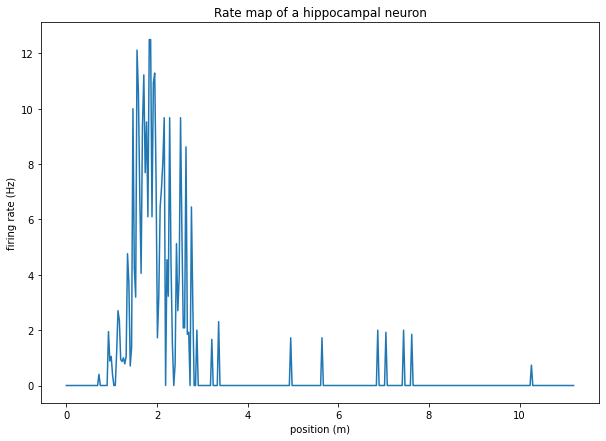

In [6]:
# if you haven't already, convert theta (NOT cumulative theta) into a measure of distance
pos = circumf * theta/(2*np.pi)

# 1. define position bins
dpos = 0.03 # three cm
pos_bins = np.arange(np.min(pos),np.max(pos),dpos)

# 2. get the positions at which the spikes occurred
# we know the time of each position (ts) and the time of each spike (spike_times)
# we need to find the point of ts that spike_times is closest to
# this will give us the location of the animal at that point, which is the spike position
# hint: a useful function to use is np.digitize
spike_inds = np.digitize(spike_times,ts)
spike_pos = pos[spike_inds]

# 3. count the number of spikes in each position bin
spike_counts,_ = np.histogram(spike_pos,pos_bins)

# 4. compute the occupancy for each position
n_samples,_ = np.histogram(pos,pos_bins)
t_sample = np.mean(np.diff(ts))
occupancy = t_sample * n_samples

# 5. compute the rate map
rate_map = spike_counts/occupancy

# 6. plot results
plt.figure(figsize=(10,7))
plt.plot(pos_bins[:-1],rate_map);
plt.xlabel('position (m)')
plt.ylabel('firing rate (Hz)')
plt.title('Rate map of a hippocampal neuron')
plt.show()


There are actually 20 neurons included in CRE181's dataset. Once you get you rate map working on the first one, you can repeat the process for the remaining neurons -- you can even plot them all together using ``plt.subplots``. 

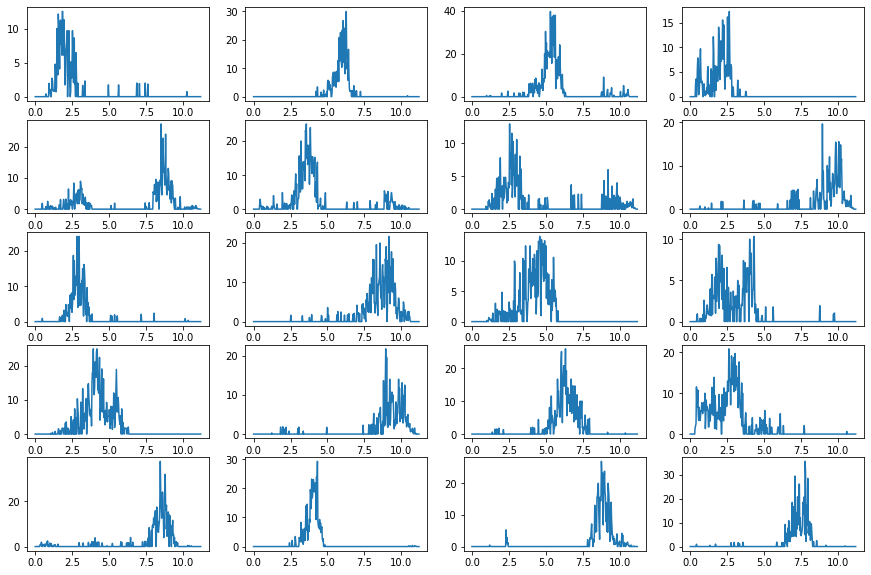

In [7]:
_,axs = plt.subplots(5,4,figsize=(15,10))
nrow = 0
ncol = 0

# for loop to plot
for i in np.arange(20):
    spike_times = data[0][i]
    
    # 2. get the positions at which the spikes occurred
    # hint: a useful function to use is np.digitize
    spike_inds = np.digitize(spike_times,ts)
    spike_pos = pos[spike_inds]

    # 3. count the number of spikes in each position bin
    spike_counts,_ = np.histogram(spike_pos,pos_bins)

    # 4. compute the occupancy for each position
    n_samples,_ = np.histogram(pos,pos_bins)
    t_sample = np.mean(np.diff(ts))
    occupancy = t_sample * n_samples

    # 5. compute the rate map
    rate_map = spike_counts/occupancy

    axs[nrow,ncol].plot(pos_bins[:-1],rate_map)
    
    if ncol < 3:
        ncol+=1
    else:
        nrow+=1
        ncol=0

Look at all of those place fields! Of course, position isn't the only variable we'll every want to look at for neural tuning. The more general general analysis to examing firing rates with respect to environmental variables is referred to as a **peristimulus time histogram** or PSTH. It is calculated in essentially the same way as a rate map, except instead of position bins, you define time bins that correspond to a specific stimulus or event.

**BONUS:** A cool way to visualize multiple rate maps together is to sort them in order of their peaks and plot them using a 2D heat map such as ``plt.pcolormesh``. See if you can do this! You'll see a cool result: that these place cells tile the environmentment and together form a spatial sequence.

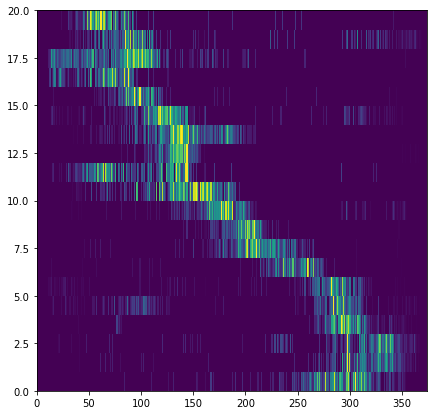

In [8]:
# for loop to plot
rate_maps = np.zeros((20,np.size(pos_bins)-1))

for i in np.arange(20):
    spike_times = data[0][i]
    
    # 2. get the positions at which the spikes occurred
    # hint: a useful function to use is np.digitize
    spike_inds = np.digitize(spike_times,ts)
    spike_pos = pos[spike_inds]

    # 3. count the number of spikes in each position bin
    spike_counts,_ = np.histogram(spike_pos,pos_bins)

    # 4. compute the occupancy for each position
    n_samples,_ = np.histogram(pos,pos_bins)
    t_sample = np.mean(np.diff(ts))
    occupancy = t_sample * n_samples

    # 5. compute the rate map
    rate_map = spike_counts/occupancy
    rate_maps[i,:] = rate_map/np.max(rate_map)

  
peaks = np.argmax(rate_maps,1) 
inds = np.argsort(-peaks)

plt.figure(figsize=(7,7))
plt.pcolormesh(rate_maps[inds,:])
plt.show()    

---
## 3. Gradients: Reinforcement Learning

A prominant theory in decision making is that there are two competing systems of control: one that generates reflective or *goal-directed* actions, and one that generates reflexive or *habitual* actions (Dolan & Dayan, *Nature*, 2013; Gremel & Costa, *Nat. Comm.*, 2013). Being able to distingush between these types of behavior, especially during tasks where both are present, allows experimenters to better understand how these systems interact as an animal's behavior evolves throughout a given task. A popular task used to study these competeing systems is known as the *two-step task*. First introduced in humans (Daw et al., *Neuron*, 2011), this task has been shown to elicit computational analogues to both goal-directed and habitual behavior, described by model-based and model-free reinforcement learning (RL) respectively. Both model-based and model-free RL algorithms are still widely used to classify behvaior (although it's mapping onto goal-directed vs habitual behavior is disputed (Miller et al., *Psych. Review*, 2019)), allowing for explicit testing and dissociation of neural circuits underlying these two systems.

> **DISCLAIMER:** This is a doozy of an exercise that entails computing analytical derivatives. If you're not interested in this level of calculus application, skip to the last exercise.

**Reinforcement learning** is a deep and complex area of machine learning that, with no prior background, will be hard to adequately introduce for this exercise. At it's core, RL is a computational approach to learning from interaction, and draws influence from work in artificial intelligence as well as the psychology of animal learning (Sutton & Barto, *Reinforcement Learning*, 1998). RL is known as an *unsupervised* learning method, in that the learner is not told what actions to take, but instead learns by "trial-and-error", thereby discovering which actions to take by trying them and learning which actions yield the most reward. Exactly *how* the agent learns from the outcomes of their actions is detailed by various implementations of RL which generally fall under two umbrellas: *model-free* and *model-based* RL. *Model-free* implementations are generally more computationally eficient; after experiencing a rewarding outcome (or a punishing outcome), a model-free learner will apply that value to the previous action (or string of actions) that lead there. In this way, a model-free learning has a representation of which actions are good or bad, but no knowledge of *how* actions lead to good or bad outcomes, similar to habitual or reflexive actions that repeat "good" actions without context of *why* it's good. In contrast, *model-based* implementations additionally learn *how* actions lead to outcomes, akin to a "mental map" of the action-outcome space. This allows a model-based learner to apply outcome values to *all possible* actions that lead to that outcome, even actions not recently taken. Additionally, this action-outcome model can be used to *plan* future actions by sampling the action space to figure out which action leads to the best outcome, similar to reflective and goal-directed behavior. However, this comes at the cost of computational demand; as the action space grows larger, it takes longer to search through and compare available actions.

In this exercise, we'll introduce rudimentary equations for both model-based and model-free RL in the context of a simpler version of two-step task used in rats (Miller et al., *Nat. Neuro*, 2017). This version of the task limits the number of possible action and outcome states, which greatly simplifies the set of equations used to describe model-free and model-based RL. We'll use these equations to practice computing gradients that can be used to assist in model fitting. While we're treading close to putting the cart before the horse since we haven't covered model fitting, we'll boil it down to just the calculus and hopefully demonstrate where it falls in the process.

### 3.1 Task & Model Setup
Let's introduce the task by looking at first figure from Miller et al. (2017) shown below.

<img src="twostep.png" width=600>

In this version of the two-step task, rats are placed in a behavioral chamber with six ports: three in the top row corresponding to the "first step", and three in the bottom row corresponding to the "second step" (**Figure 1b**). The structure of the trial is shown in **Figure 1a**. The rat initiates a trial by poking into the top center port (**i**); afterwards, lights will turn on in the adjacent left and right ports, indicating that the rat can choose between the two (**ii**). After making a choice, a sound will play that indicates which second-step outcome port will be lit up and available to enter (**iii**). The rat then initiates the second step by poking in the bottom center port (**iv**), after which the indicated outcome port is lit (**v**). The animal can only enter the lit outcome port, during which he may or may not recieve a liquid reward (**vi**). The available outcome port is probabilistically dependent on the choice that the animal made in the first step: if the rat chose left, there is an 80% chance he will end up at the bottom left outcome port (denoted the *common transition*) and a 20% chance that he'll end up at the bottom right port (denoted the *rare transition*); if the rat chose right, the opposite is true. A second, unrelated probability governs the chance of recieving reward at an outcome port: one port will have an 80% chance of reward and the opposite a 20% chance. The "better" outcome port will flip unpredictably throughout a session (**Figure 1c**); therefore, the rat must track which outcome port has the higher chance of reward and choose the top-level port most-likely to lead there. The green traces in panels **c** and **d** demonstrate that the rats are able to adapt their choices to reward block switches.

Next we'll walk through the model we'll use to describe the rat's behavior in this task. As mentioned briefly in lecture, model-fitting involves finding a set of parameters that maximize the likelihood of the behavioral model. In this example, the likelihood of the model is the probability that the animal will make a left or right choice, which can be described by a softmax function:

$$
P(choice) = \frac{e^{Q_{net}(choice)}}{e^{Q_{net}(right)} + e^{Q_{net}(left)}}
$$

where $choice \in [left,right]$ and $Q_{net}$ is the *choice value*, which is a measure of how *good* a left or right choice is based on previous experience. Since there are only two choices, and $P(right) = 1-P(left)$, we can compute the likelihood by only using the above equation with respect to left choices. Given a choice $c \in [0,1]$, where $0$ corresponds to a right choice and $1$ corresponds to a left choice, the likelihood of that choice on a given trial can be represented as a binomial function:

$$
P(c) = P(left)^{c} * (1-P(left))^{1-c}\tag{3.1.1}
$$

In order to compute the likelihood across *all* trials, we'll need to **multiply** the likelihoods of each trial. In other words, for a vector of choices $C = (c_1,c_2,...,c_T)$ over $T$ total trials, the total likelihood becomes

$$
P(C) = \prod_{t=1}^T P(c_t)\tag{3.1.2}
$$

> It should be noted that $P(left)$ is also dependent on trial $t$ since $Q_{net}$ is dependent on trial $t$. However, instead of adding in additional subscripts for notation, we'll be defining $Q_{net}$ recursively, therefore updating its value for each trial within a for-loop. In this way, we will be iteratively accumulating the likelihood $P(C)$ instead of computing the full product at once. 

We can then simplify $P(left)$ into a logistic sigmoid:

$$
P(left) = \frac{1}{1 + e^{-(Q_{net}(left)-Q_{net}(right))}}\tag{3.1.3}
$$

To measure the relative contributions of model-based and model-free RL to decision making in this task, we'll assume that the net choice value, $Q_{net}$, is a weighted sum of values computed by model-free, $Q_{mf}$, and model-based, $Q_{mb}$ algorithms, 

$$
Q_{net}(choice) = \beta_{mf}Q_{mf}(choice) + \beta_{mb}Q_{mb}(choice)\tag{3.1.4}
$$

Actually computing $Q_{mf}$ and $Q_{mb}$ is where we finally introduce our RL algorithms. We'll start with *model-free RL*. As stated previously, model-free RL describes how the value of *selected* actions are updated by *immediate* outcomes. One of the most basic ways to do this is to use *temporal differencen (TD) learning*, specifically **TD(0)**, where only immediate action values are updated from immediate outcomes. (This is in contrast to other implementations of TD learning, e.g. TD(1) and TD($\lambda$), which can allow updating of action values multiple steps in the past). In this task, TD(0) would be implemented as follows. 

1) For the first step, after the animal makes a choice and the outcome state is known, the value of that choice is updated according to:

$$
Q_{mf}(choice) \leftarrow Q_{mf}(choice) + \alpha (V(outcome) - Q_{mf}(choice))\tag{3.1.5}
$$

where $\alpha$ is the *learning rate* and $V(outcome)$ is the expected value of the outcome state. The "temporal difference" refers to the term $V(outcome) - Q_{mf}(choice)$, which represents the difference in the expected value of the choice, $Q_{mf}(choice)$, and the value of the outcome experienced, $V(outcome)$. If this value is *negative*, then the outcome was *worse* than what was expected, therefore *decreasing* the value of this choice. If this value is *positive*, the outcome was *better* than expected, therefore *increasing* the value of this choice. The learning rate $\alpha$ determines how quickly values are updated, or how influential new observations are to the existing choice value. This equation represents a recursive relationship of the choice value across trials, meaning that the updated $Q_{mf}$ on the left-hand side requires the previous trial's value of $Q_{mf}$, used in the sum on the right-hand side.

2) For the second step, after the animal enters the outcome state and recieves (or doesn't recieve) reward, the value of the outcome stat is updated by:

$$
V(outcome) \leftarrow V(outcome) + \alpha (r - V(outcome))\tag{3.1.6}
$$

where $r$ is a binary value indicating whether or not a reward was recieved. This $r$ can also be thought of as the *reward value*, which is NOT the same as the outcome value $V$ (you can imagine the outcome value $V$ as the *expected* reward value, and $r$ and the *actual* reward value). Note that the outcome value is also a recursive relationship as described above, and the temporal difference compares the expected value of the outcome to the actual reward recieved.

Next, we'll use *model-based RL* to compute $Q_{mb}$. As stated previously, model-based RL utilizes an *action-outcome model* of the task to update action values instead of only updating immediate or taken choices. This action-outcome model can be represented as a *transition matrix* that describes how action states lead to outcome states. In this way, model-based RL can update both *taken* and *non-taken* action values if those actions are known to lead to the observed outcome. In the context of the two-step task, this allows the animal to attribute the outcome value to it's *common* choice port, even if the animal didn't actually take that action.

Model-based RL is typically modelled using the **Bellman equation**, which for this task is:

$$
Q_{mf}(choice) = \sum_{outcome \in [left,right]} V(outcome) * T(choice,outcome)
$$

Where $V(outcome)$ is the same value computed previously, and $T$ is a transition matrix that describes the transition probability for each choice-outcome pair. In this task, we assume that that animal has learned the true transition matrix, making the common transitions $T(left,left) = T(right,right) = 0.8$, and the uncommon transitions $T(left,right) = T(right,left) = 0.2$. More explicitly, after updating the outcome value $V$, the model-based choice values are updated according to:

$$
Q_{mb}(left) = 0.8*V(left) + 0.2*V(right)  \\
Q_{mb}(right) = 0.2*V(left) + 0.8*V(right)\tag{3.1.7}
$$

### 3.2 Coding the Likelihood Function

With all the relevant functions introduced, we can now build our likelihood function to fit the model. There are three free parameters that we need to fit: $\beta_{mf}$, $\beta_{mb}$, and $\alpha$. The likelihood function we introduced in equations (3.1.1) and (3.1.2) is how we'll compute the "landscape" over which to optimize these parameters. 

First, to simplify the computation of (3.1.1) and (3.1.2), we'll be optimizing over the *log-likelihood* instead of the raw likelihood. Second, for reasons beyond this exercise, we'll want to take the *negative* log-likelihood in order to do *minimization*. Therefore, for a given set of $[\beta_{mf},\beta_{mb},\alpha]$, we'll want our likelihood function to output the negative log-likelihood, which we'll store in the variable $f$. For each trial, we'll iteratively accumulate the likelihood by

$$
f += -\big(c\ln(P(left)) + (1-c)\ln(1-P(left))\big)\tag{3.2.1}
$$

where $c\in[0,1]$ is the choice for the given trial, where $0$ is a right choice and $1$ is a left choice. 

To compute $P(left)$, we'll introduce some variable substitutions to combine equations (3.1.3) and (3.1.4). For our choice values, we'll use a column vector $Q_{diff}$, defined as:

$$
Q_{diff} = \begin{pmatrix} Q_{mf}(left)-Q_{mf}(right) \\ Q_{mb}(left)-Q_{mb}(right) \end{pmatrix}
$$

We'll similarly combine our model-free and model-based weights into a single row vector $\beta$, defined as:

$$
\beta = \begin{pmatrix} \beta_{mf} && \beta_{mb} \end{pmatrix}
$$

Putting these together, we can simplify equation (3.1.3) as:

$$
P(left) = \frac{1}{1 + e^{-\beta Q_{diff}}} \tag{3.2.2}
$$

where the term $\beta Q_{diff}$ is a dot product equivalent to equation (3.1.4).

To compute $Q_{mf}$ and $Q_{mb}$ for $Q_{diff}$, we'll use equations (3.1.5-7) introduced above. Specifically,

$$
Q_{mf}(choice) \leftarrow Q_{mf}(choice) + \alpha (V(outcome) - Q_{mf}(choice))\tag{3.2.3}
$$

$$
V(outcome) \leftarrow V(outcome) + \alpha (r - V(outcome))\tag{3.2.4}
$$

$$
Q_{mb}(left) = 0.8*V(left) + 0.2*V(right)  \\
Q_{mb}(right) = 0.2*V(left) + 0.8*V(right)\tag{3.2.5}
$$

where $choice$ and $outcome$ correspond to the chosen action and experienced outcome on that trial, and $r$ the experienced reward on that trial.

Since this exercise is about computing the gradients and not setting up the base likelihood function, I've already provided the code to compute the likelihood below. We'll also use behavioral data from a polite rat, M070, who has done a very good job on the two-step task, to test out the model.

In [9]:
#####-- load in data --#####
tmp = loadmat('M070_twostep_data.mat');
ratdata = tmp['ratdata']
choices = ratdata['choices'][0][0]
outcomes = ratdata['outcomes'][0][0]
rewards = ratdata['rewards'][0][0]

#####-- define the likelihood function --#####
def negloglik(params,choices,outcomes,rewards):
    betas = params[:2]
    alpha = params[2]
    
    # initialize all values to 0.5
    Qmf = np.ones(2)*0.5
    Qmb = np.ones(2)*0.5
    V = np.ones(2)*0.5
    Qdiff = np.zeros(2) # this is just a holder variable

    # start accumulator at 0
    f = 0
    for c,o,r in zip(choices,outcomes,rewards):
        # the choice value at the beginning of the trial is the choice value computed at the end of the previous trial
        Qdiff[0] = Qmf[1] - Qmf[0]  # put the model-free difference in the first index, left - right
        Qdiff[1] = Qmb[1] - Qmb[0]  # put the model-based difference in the second index, left - right

        # compute p_left for the likelihood computation
        p_left = 1/(1+np.exp(-betas@Qdiff))
        
        # accumulate negative log-likelihood value
        f += -(c*np.log(p_left) + (1-c)*np.log(1-p_left))
        
        #####-- update the values for the next trial --#####
        # first, update the model-free choice value given the observed outcome
        Qmf[c] += alpha*(V[o]-Qmf[c])

        # second, update the outcome value given the observed reward
        #dV[o] += r - V[o] - alpha*dV[o] 
        V[o] += alpha*(r - V[o])
        
        # third, update the model-based choice values given the updated outcome value
        Qmb[1] = 0.8*V[1] + 0.2*V[0] # left choice value
        Qmb[0] = 0.2*V[1] + 0.8*V[0] # right choice value
        
    return f


#####-- fit the model --#####
start_time = time.time()  # to track how long it takes to fit
init_params = (1,1,0.5)   # generally you'd have a random initialization, but we'll choose a fixed point so that we can compare the runtime to our version with the gradient
# this is the function that does gradient descent. I wouldn't worry too much about the inputs in the context of this exercise
params = scipy.optimize.minimize(negloglik,x0=init_params,args=(choices,outcomes,rewards),method='L-BFGS-B')
end_time = time.time()
print('betaMF = ',params.x[0],'\nbetaMB = ',params.x[1],'\nalpha = ',params.x[2],'\nruntime = ',end_time-start_time, ' s')

betaMF =  0.130368097960476 
betaMB =  2.4696355816163598 
alpha =  0.628508014947211 
runtime =  15.9968900680542  s


Running the above block of code should show a fit of betaMF = 0.13, betaMB =  2.47, alpha =  0.63. Just like in Miller et al. (2017), this model demonstrates that M070 is much more model-based than he is model-free.

If you can run the block of code above, then congradulations! You've just fit a behavioral model! Besides reading the longest exercise of your life, however, you probably feel like you haven't done anything. By default, minimization packages in python don't require a gradient in the likelihood function; these packages contain tools that perform automatic differentiation (e.g. they numerically approximate the derivative) to do gradient descent. While relying on automatic differentiation is a fine thing to do when model fitting, and usually easier to implement, it can also cause the minimization process to take much, much longer. Therefore, providing an analytical gradient where possible can speed up the model-fitting process; with larger models, this can be a difference of days to hours. 

### 3.3 Adding the Gradients
With three free parameters in our model, $[\beta_{mf},\beta_{mb},\alpha]$, we'll need an output gradient with *three* values corresponding to each of these parameters, which we'll store in the variable $g$.

$$
g = \begin{pmatrix} \frac{\partial f}{\partial \beta_{mf}} && \frac{\partial f}{\partial \beta_{mb}} && \frac{\partial f}{\partial \alpha} \end{pmatrix}
$$

Similar to how we've computed the likelihood, we can also iteratively sum the gradient (recall: $\frac{d}{dx}(c\cdot f(x) \pm d\cdot g(x)) = c\cdot f'(x) \pm d\cdot g'(x)$). Therefore, the analytical gradient can be computed for a single trial using equations (3.2.1-5), and added together within the for-loop.

Modify the function below to iteratively compute the gradient. If it's right, you should have the get the same values for $\beta_{mf}$, $\beta_{mb}$, and $\alpha$ as computed above in the likelihood-only function.

**Hints:**
1. The gradients of $\beta_{mf}$ and $\beta_{mb}$ can be computed together using matrix math.
2. The logistic sigmoid has a well-defined gradient -- you can try it by hand, but don't be afraid to look up resources online!
3. You'll need to use the chain rule to compute $\frac{\partial f}{\partial \alpha}$

In [10]:
#####-- load in data --#####
tmp = loadmat('M070_twostep_data.mat');
ratdata = tmp['ratdata']
choices = ratdata['choices'][0][0]
outcomes = ratdata['outcomes'][0][0]
rewards = ratdata['rewards'][0][0]

#####-- define the likelihood function --#####
def negloglik_grad(params,choices,outcomes,rewards):
    betas = params[:2]
    alpha = params[2]
    
    # initialize all values to 0.5
    Qmf = np.ones(2)*0.5
    Qmb = np.ones(2)*0.5
    V = np.ones(2)*0.5
    Qdiff = np.zeros(2) # this is just a holder variable

    # initialize all derivatives to 0
    dQmf = np.zeros(2)
    dQmb = np.zeros(2)
    dV = np.zeros(2)
    dQdiff = np.zeros(2)

    # start accumulators at 0
    f = 0
    g_betas = np.zeros(2)
    g_alpha = 0
    for c,o,r in zip(choices,outcomes,rewards):
        # the choice value at the beginning of the trial is the choice value computed at the end of the previous trial
        Qdiff[0] = Qmf[1] - Qmf[0]  # put the model-free difference in the first index, left - right
        Qdiff[1] = Qmb[1] - Qmb[0]  # put the model-based difference in the second index, left - right
        
        # --- ADD CODE HERE ---#
        # gradient of Qdiff
        # dQdiff[0] = 
        # dQdiff[1] = 

        # compute p_left for the likelihood computation
        p_left = 1/(1+np.exp(-betas@Qdiff))
        
        # accumulate negative log-likelihood value
        f += -(c*np.log(p_left) + (1-c)*np.log(1-p_left))
             
        # --- ADD CODE HERE ---#
        # accumulate gradients
        # g_betas += 
        # g_alpha += 
        
        #####-- update the values for the next trial --#####
        # --- ADD CODE HERE ---#
        # compute the gradent of the model-free choice value
        # dQmf[c] += 
        
        # first, update the model-free choice value given the observed outcome
        Qmf[c] += alpha*(V[o]-Qmf[c])
        
        # --- ADD CODE HERE ---#
        # compute the gradient of the outcome value
        # dV[o] += 
        
        # second, update the outcome value given the observed reward
        V[o] += alpha*(r - V[o])
        
        # --- ADD CODE HERE ---#
        # compute the gradient of the model-based choice values
        # dQmb[1] = 
        # dQmb[0] =
        
        # third, update the model-based choice values given the updated outcome value
        Qmb[1] = 0.8*V[1] + 0.2*V[0] # left choice value
        Qmb[0] = 0.2*V[1] + 0.8*V[0] # right choice value
        
    g = np.hstack((g_betas,g_alpha))

    return f,g


#####-- fit the model --#####
init_params = (1,1,0.5)  # to track how long it takes to fit
start_time = time.time() # generally you'd have a random initialization, but we'll choose a fixed point so that we can compare the runtime to our version with the gradient
# this is the function that does gradient descent. I wouldn't worry too much about the inputs in the context of this exercise
# however, note that the flac "jac=True" was added to specify that we're providing a gradient
params = scipy.optimize.minimize(negloglik_grad,x0=init_params,args=(choices,outcomes,rewards),method='L-BFGS-B',jac=True)
end_time = time.time()
print('betaMF = ',params.x[0],'\nbetaMB = ',params.x[1],'\nalpha = ',params.x[2],'\nruntime = ',end_time-start_time, ' s')

betaMF =  1.0 
betaMB =  1.0 
alpha =  0.5 
runtime =  0.2836318016052246  s


### SOLUTION
gradient of Betas = 
$$
\frac{\partial f}{\partial \beta} = \sum_{trials} (P(left) - choice) * Q_{diff}
$$

gradient of learning rate = 
$$
\frac{\partial f}{\partial \alpha} = \frac{\partial f}{\partial Q_{diff}} * \frac{\partial Q_{diff}}{\partial \alpha} 
$$

$$
\frac{\partial f}{\partial Q_{diff}} = \sum_{trials}(P(left) - choice) * \beta
$$

$$
\frac{\partial Q_{diff}}{\partial \alpha} = \begin{pmatrix} \frac{\partial Q_{mf}(left)}{\partial \alpha} - \frac{\partial Q_{mf}(right)}{\partial \alpha} \\ \frac{\partial Q_{mb}(left)}{\partial \alpha} - \frac{\partial Q_{mb}(right)}{\partial \alpha} \end{pmatrix}
$$

$$
\frac{\partial Q_{mf}(choice)}{\partial \alpha} \leftarrow \frac{\partial Q_{mf}(choice)}{\partial \alpha} + V(outcome) - Q_{mf}(choice) + \alpha\bigg(\frac{\partial V(outcome)}{\partial \alpha} - \frac{\partial Q_{mf}(choice)}{\partial \alpha}\bigg)
$$

$$
\frac{\partial V(outcome)}{\partial \alpha} \leftarrow (1 - \alpha)\frac{\partial V(outcome)}{\partial \alpha} + r - V(outcome)
$$

$$
\frac{\partial Q_{mb}(left)}{\partial \alpha} = 0.8 * \frac{\partial Q_{mb}(left)}{\partial \alpha} + 0.2 * \frac{\partial Q_{mb}(right)}{\partial \alpha} \\
\frac{\partial Q_{mb}(right)}{\partial \alpha} = 0.2 * \frac{\partial Q_{mb}(left)}{\partial \alpha} + 0.8 * \frac{\partial Q_{mb}(right)}{\partial \alpha}
$$

In [11]:
#####-- load in data --#####
tmp = loadmat('M070_twostep_data.mat');
ratdata = tmp['ratdata']
choices = ratdata['choices'][0][0]
outcomes = ratdata['outcomes'][0][0]
rewards = ratdata['rewards'][0][0]

#####-- define the likelihood function --#####
def negloglik_grad(params,choices,outcomes,rewards):
    betas = params[:2]
    alpha = params[2]
    
    # initialize all values to 0.5
    Qmf = np.ones(2)*0.5
    Qmb = np.ones(2)*0.5
    V = np.ones(2)*0.5
    Qdiff = np.zeros(2) # this is just a holder variable

    # initialize all derivatives to 0
    dQmf = np.zeros(2)
    dQmb = np.zeros(2)
    dV = np.zeros(2)
    dQdiff = np.zeros(2)

    # start accumulators at 0
    f = 0
    g_betas = np.zeros(2)
    g_alpha = 0
    for c,o,r in zip(choices,outcomes,rewards):
        # the choice value at the beginning of the trial is the choice value computed at the end of the previous trial
        Qdiff[0] = Qmf[1] - Qmf[0]  # put the model-free difference in the first index, left - right
        Qdiff[1] = Qmb[1] - Qmb[0]  # put the model-based difference in the second index, left - right
          
        dQdiff[0] = dQmf[1] - dQmf[0]
        dQdiff[1] = dQmb[1] - dQmb[0]

        # compute p_left for the likelihood computation
        p_left = 1/(1+np.exp(-betas@Qdiff))
        
        # accumulate negative log-likelihood value
        f += -(c*np.log(p_left) + (1-c)*np.log(1-p_left))
             
        # accumulate gradients
        g_betas += (p_left-c)*Qdiff
        g_alpha += (p_left-c)*(betas@dQdiff)
        
        #####-- update the values for the next trial --#####
        # first, update the model-free choice value given the observed outcome
        dQmf[c] += V[o] - Qmf[c] + alpha*(dV[o]-dQmf[c])
        Qmf[c] += alpha*(V[o]-Qmf[c])

        # second, update the outcome value given the observed reward
        dV[o] += r - V[o] - alpha*dV[o] 
        V[o] += alpha*(r - V[o])
        
        # third, update the model-based choice values given the updated outcome value
        dQmb[1] = 0.8*dV[1] + 0.2*dV[0]
        dQmb[0] = 0.2*dV[1] + 0.8*dV[0]
        Qmb[1] = 0.8*V[1] + 0.2*V[0] # left choice value
        Qmb[0] = 0.2*V[1] + 0.8*V[0] # right choice value
        
    g = np.hstack((g_betas,g_alpha))

    return f,g


#####-- fit the model --#####
#init_params = np.hstack((np.random.rand(2),np.random.beta(5,5,1)))
init_params = (1,1,0.5)
start_time = time.time()
params = scipy.optimize.minimize(negloglik_grad,x0=init_params,args=(choices,outcomes,rewards),method='L-BFGS-B',jac=True)
end_time = time.time()
print('betaMF = ',params.x[0],'\nbetaMB = ',params.x[1],'\nalpha = ',params.x[2],'\nruntime = ',end_time-start_time, ' s')

betaMF =  0.13035209836798511 
betaMB =  2.469663986361932 
alpha =  0.6285017392811583 
runtime =  8.207356214523315  s


---
## 4. Vicarious Trial and Error (VTE)

Examining contributions of model-based and model-free RL to behavior is not the only correlate that can distinguish between goal-directed and habitual behavior. Another axis that is equated to goal-directed vs habitual behavior is *deliberative* vs *procedural* control, respectively. Under this regime, deliberative control can be identified by variable behavior at decision points, akin to "weighing your options". Conversely, procedural control is described by highly repetitive, stereoryped behavior at decision points. 

In this exercise, we'll be focusing on a behavioral correlate of deliberative behavior: vicarious trial and error, or VTE. VTE is thought to be an overt expression of deliberation, especially in spatial decision tasks, where an animal manually looks in various possible directions before making a decision on which way to turn. This type of behavior has been found to co-occur with non-local representations in the hippocampus as evidence for mental deliberation. 

> **What is a non-local representation?** Recall from our exercise above where we computed *local* hippocampal representations, where neurons were firing at their preferred location when the animal was physically occupying that location. A *non-local* representation occurs when hippocampal cells fire for locations that the animal is *not* presently occupying, which is thought to demonstrate the animal *imagining* that it's moving to those locations.

Figuring out whether an animal has engaged in VTE is a similar (and much more behaviorally interesting) problem to figuring out how far an animal moved, as in our lecture example for integrals. However, instead of computing distance, this integral captures how long the rat hesitates at a choice point and how quickly the rats head is changing direction, making this a combination of numerical integrals *and* derivatives. Specifically, this can be computed by the following equation (pulled from Hasz & Redish, *Frontiers*, 2018)

$$
\text{LogIdPhi} = log \left( \int_{zone-entry}^{zone-exit} \bigg|\frac{\delta}{\delta t} \text{atan2}\left(\frac{\delta y}{\delta t},\frac{\delta x}{\delta t}\right)\bigg|\delta t \right)
$$

To numerically evaluate this equation, we'll use some behavioral data of a rat performing the two-step task introduced in exercise 3. Another polite rat, M120, has graciously given us some data of him doing a very good job on the two-step task, in addition to DeepLabCut position tracking data on the location of his nose throughout the session. An examply of a nose position is in the following picture, where his nose is labelled with the dark blue circle:

<img src="M120.png" width=600>

As you can see, we have a top-down view of the rig instead of a front view as in **Figure 1b** above. With this angle, we'll be looking at VTE in the x- (left to right of the frame) and y-dimensions (top to bottom of the frame) after trial initiation to see if he deliberates between the left and right ports before making a choice. These values by themselves, however, aren't very meaningful without some kind of baseline. Therefore, we'll also look at VTE during the second step where *no* choice is involved; ideally, there should be *no* VTE when the movement at the second step is instructed.

Below, I have provided code to load in M120's session data. Variables you will have access to are:
- ``c1_times``: (593x1) array of times, for each trial, when the rat enters the top center port. This is when the trial is initiated.
- ``s1_times``: (593x1) array of times when the rat enters either one of the top side ports, either left or right, on each trial. This is when the animal makes the choice.
- ``c2_times``: (593x1) array of times when the rat enters the bottom center port. This is when the second step of the trial is initiated.
- ``s2_times``: (593x1) array of times when the rat enters one of the bottom side ports, either left or right. This is when the animal completes the trial and recieves reward.
- ``noseloc``: (152006x2) array of the rat's nose positions for each video frame. The first column is the x-dimension and the second column is the y-dimension.
- ``vid_ts``: (152006x1) array of the time stamps that each video frame occurrs.

This should be all you need to compute LogIdPhi and approximate VTE for each trial. Specifically you should:
1. Compute LogIdPhi for each trial during the first step choice (between c1_times and s1_times)
2. Compute LogIdPhi for each trial during the second step outcome (between c2_times and s2_times)
3. Plot LogIdPhi as a function of trials for both steps to see how the values change over the session
4. Plot a histogram of LogIdPhi values for both steps to compare any differences between their distributions

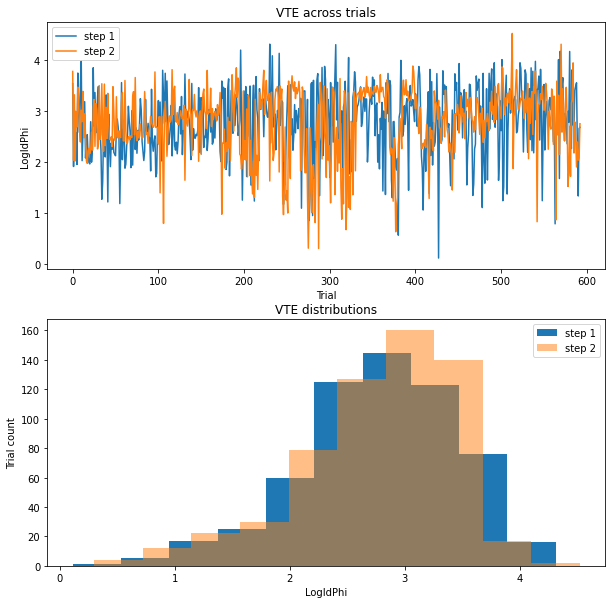

In [12]:
#####-- load in data --#####
tmp = loadmat('M120_twostep_data.mat');
ratdata = tmp['ratdata']
c1_times = ratdata['c1_times'][0][0]
s1_times = ratdata['s1_times'][0][0]
c2_times = ratdata['c2_times'][0][0]
s2_times = ratdata['s2_times'][0][0]
noseloc = ratdata['noseloc'][0][0]
vid_ts = ratdata['vid_ts'][0][0][0]

#####-- compute LogIdPhi --#####
step1_LIP = np.zeros(len(c1_times))  # variable to store LIP at the first step
step2_LIP = np.zeros(len(c1_times))  # variable to store LIP at the second step
for i in np.arange(len(c1_times)):

    ## 1. find the video frames corresponding the first and second steps and get relevant position and time data
    step1_start = np.argmin(np.abs(vid_ts-c1_times[i]))   # first frame index is the min distance between the video frame timestamps and this trial's c1_time
    step1_end = np.argmin(np.abs(vid_ts-s1_times[i]))     # last frame index is the min distance between the video frame timestamps and this trial's s1_times
    step2_start = np.argmin(np.abs(vid_ts-c2_times[i]))   # first and last frame same as above for 2nd step, except using c2_times and s2_times
    step2_end = np.argmin(np.abs(vid_ts-s2_times[i]))

    step1_noseloc = noseloc[step1_start:step1_end,:]      # store the nose positions for step 1 using the starting and ending frame indices
    step1_vid_ts = vid_ts[step1_start:step1_end]          # store the video timestamps for step 1 using the starting and ending frame indices
    step2_noseloc = noseloc[step2_start:step2_end,:]      # repeat for step 2
    step2_vid_ts = vid_ts[step2_start:step2_end]
    
    ## 2. compute LogIdPhi for each step
    # step 1
    dpos = np.diff(step1_noseloc,axis=0)   # find change in position by taking the difference in the x- and y-dimensions
    dt = np.diff(step1_vid_ts)             # find change in time by taking the difference between timestamps

    dx_dt = dpos[:,0]/dt                   # dx/dt is the difference in x (first column) divided by the difference in time
    dy_dt = dpos[:,1]/dt                   # dy/dt is the difference in y (first column) divided by the difference in time

    # LIP according to given equation
    step1_LIP[i] = np.log(np.sum(np.abs(np.arctan2(dy_dt,dx_dt)/dt)*dt))
    
    # repeat above for step 2
    dpos = np.diff(step2_noseloc,axis=0)   
    dt = np.diff(step2_vid_ts)

    dx_dt = dpos[:,0]/dt
    dy_dt = dpos[:,1]/dt

    step2_LIP[i] = np.log(np.sum(np.abs(np.arctan2(dy_dt,dx_dt)/dt)*dt))

#####-- plot results --#####  
## 3. plot LIP for both steps as a function of trials
_,axs = plt.subplots(2,1,figsize=(10,10))
axs[0].plot(step1_LIP)
axs[0].plot(step2_LIP)
axs[0].set_xlabel('Trial')
axs[0].set_ylabel('LogIdPhi')
axs[0].set_title('VTE across trials')
axs[0].legend(['step 1','step 2'])

## 4. plot LIP distributions for both steps
axs[1].hist(step1_LIP);
axs[1].hist(step2_LIP,alpha=0.5);
axs[1].set_xlabel('LogIdPhi')
axs[1].set_ylabel('Trial count')
axs[1].set_title('VTE distributions')
axs[1].legend(['step 1','step 2']);

If you've successfully completed the above exercise, you may find the results underwhelming; there doesn't seem to be a disernable difference between VTE during a choice at the first step and VTE during an instructed action at the second step. There are a few possible explanations for this: 1) M120 doesn't engage in VTE, and the overt behavior doesn't necessarily reflect model-based behavior in this task. 2) Using VTE at the second step may not be a fair baseline to look at VTE from the first step; for example, if the animal experiences a *rare* transision, he may start to move toward the unlit, common outcome port before moving towards the lit, rare outcome port, and this movement could translate into a large LogIdPhi value. 3) Combining VTE across *all* trials may average out some of the nuances in the task design that could elicit VTE; for example, VTE may be more prevalent following an *unrewarded* trial, or may be more prevalent in trials following a reward flip.

**OPTIONAL:** There are some additional parameters contained in the "ratdata" variable, specifically:
- ``rewards``: (593x1) logical array of rewards for each trial
- ``trans_common``: (593x1) logical array of whether or not the experienced transition was common (1=common, 0=rare)
- ``leftprobs``: (593x1) array of reward probabilities for the bottom left port. Flips between 0.8 and 0.2, signalling high and low left reward blocks (right reward probabilities are $1-leftprobs$
- ``sides1``: (593x1) array of side ports visited during the first step (1=left, 0=right)
- ``sides2``: (593x1) array of side ports visited during the second step (1=left, 0=right)

Can you use these additional variables to figure out whether VTE is dependent on various task parameters?

In [13]:
# this one is pretty open ended, some examples would be:
# - compute LIP separately for trials following a reward vs. and omission
# - compute LIP separately for trials following a common vs. rare trial
# - compute the average LIP over trials following a reward flip